# Introduction to Figure 5

This document describes how to generate figure 5 of the ensemble neural coding paper. It goes into a lot of detail because this is the first notebook to document zeebeez3. Eventually the information here will be broken down into multiple notebooks. 

## The preprocessing of acoustic stimuli

The tuning curves in figure 5a are built from encoders that predict either the trial-averaged spike rate or the trial-averaged overall power in an LFP band in response to a single acoustic syllable. The syllable has been quantified using the soundsig.sound.BioSound class. The actual processing sequence for the acoustic data is as follows:

1. The [zeebeez3.transforms.Biosound](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/transforms/biosound.py) class reads a [zeebeez3.core.Experiment](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/core/experiment.py) object and segments the syllables of the acoustic stimuli for a recording session.

2. The [zeebeez3.transforms.Biosound](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/transforms/biosound.py) class uses [soundsig.sound.BioSound](https://github.com/theunissenlab/soundsig/blob/master/soundsig/sound.py) to quantify the acoustic features of each unique syllable.

3. The [zeebeez3.transforms.Biosound](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/transforms/biosound.py) class writes the acoustic feature vector for each syllable to a file, that is located in:
> /auto/tdrive/mschachter/data/<bird_name>/transforms/BiosoundTransform_<bird_name>.h5

4. After the h5 files are generated for all recording sessions across all birds, the [zeebeez3.aggregators.biosound.AggregateBiosounds](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/aggregators/biosound.py) object is used to aggregate the biosounds across birds. The final aggregate biosounds file is written to:

> /auto/tdrive/mschachter/data/aggregate/biosound.h5

It is this aggregate biosound.h5 file that is used by the encoder.

## The preprocessing of LFP and spike data

The stimulus-conditioned spike and LFP data follow a separate processing path:

1. The raw data (with low-passed LFP and spike-sorted + multiunit spikes) is written to .nwb files. There is one .nwb file per session. *NOTE: this is a work-in-progress, and the notebook currently runs off of files that were generated from a different hdf5-based source.*

2. The raw data is read from .nwb files into a [zeebeez3.core.Experiment](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/core/experiment.py) object, which provides useful functions for accessing spikes, LFP, and stimulus information. *NOTE: this is also a work-in-progress*

3. The raw data is preprocessed to make stimulus-conditioned data easier to access, using [zeebeez3.transforms.stim_event.StimEventTransform](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/transforms/stim_event.py). The stimulus-conditioned data is located in hdf files at:
> /auto/tdrive/mschachter/data/*bird*/transforms/StimEventTransform_*bird*\_*block*\_*site*\_*hemisphere*.h5
    
   For example, this is a StimEventTransform file, from a recording site that is frequently used to generate plots (*note that this file was generated on April 7, 2016*):

> /auto/tdrive/mschachter/data/GreBlu9508M/transforms/StimEvent_GreBlu9508M_Site4_Call1_L.h5

4. The spike+LFP data in the StimEventTransform file and the acoustic feature vectors in the BiosoundTransform file for a bird are then processed and joined together in the [zeebeez3.transforms.pairwise_cf.PairwiseCFTransform](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/transforms/pairwise_cf.py) class. This class does many things:

    * It zscores the LFP on each electrode using the the mean and standard deviation computed over time across all stimuli and trials.
    * It filters out syllables that are less than 50ms in duration, where syllable duration is defined as the duration of nonzero amplitude from onset to offset, plus 30ms of time following the offset.
    * For each stimulus syllable, the multi-trial, multi-electrode LFP are passed to the function *compute_lfp_spectra_and_cfs*. This is a super important function! This is where the trial-averaged power spectra, trial-mean-subtracted power spectra, and cross coherencies are computed.
    * Spike rate and spike synchrony is also computed across trials.
    * All the processed LFP and spike data is saved to an hdf5 file of the form:
    
> /auto/tdrive/mschachter/data/*bird*/transforms/PairwiseCF_*bird*\_*block*\_*site*\_*hemisphere*\_raw.h5

   For example, this is a PairwiseCF file, that corresponds to the previously mentioned StimEventTransform file:
   
> /auto/tdrive/mschachter/data/GreBlu9508M/transforms/PairwiseCF_GreBlu9508M_Site4_Call1_L_raw.h5

## Combining acoustic and neural data for use with the encoders and decoders

There is one final step, for use in the encoders and decoders. The `PairwiseCF.export_for_acoustic_decoder` method is used to export a particular LFP or spike decomposition to a file. There are several types of decompositions that can be exported indivually or combined. Each decomposition produces a feature vector, one for each syllable:

1. **full_psds**: The multi-electrode power spectra are used as the feature vector. Each power spectrum is first normalized by the maximum across all spectra, and then log transform is taken. If `merge_freqs == True`, then the power spectrum is merged into four different frequency bands (0-30Hz, 30-80Hz, 80-190Hz), before being added to the feature vector.

2. **spike_rate**: The spike rate for each neuron is used as the feature vector.

3. **spike_sync**: The pairwise spike synchrony between each neuron is used as the feature vector. It's computed as a normalized binary distance between two spike trains. For more information see the `simple_synchrony` function in [soundsig.spikes](https://github.com/theunissenlab/soundsig/blob/master/soundsig/spikes.py).

Acoustic features are also pulled in from the aggregate biosound file and a matrix is created for them. Some primitive outlier detection is used, any syllable that has an acoustic feature with a value less than the 2nd percentile or greater than the 98th percentile of the distribution of all values for that feature is discarded. Outlier detection is not applied to features computed from the fundamental frequency. 

The files exported with this data contain a "preproc_" prefix. Here are a few example files:

    /auto/tdrive/mschachter/data/GreBlu9508M/preprocess/preproc_Site4_Call1_L_full_psds.h5
    /auto/tdrive/mschachter/data/GreBlu9508M/preprocess/preproc_Site4_Call1_L_spike_rate.h5
    /auto/tdrive/mschachter/data/GreBlu9508M/preprocess/preproc_Site4_Call1_L_spike_rate+spike_sync.h5
    
Note that the last file has both the spike rate and spike synchrony in one combined feature vector. The file format of a typical preproc hdf5 file has the following datasets:

* **X**: The neural data matrix, with shape (num_syllables, num_neural_features)
* **S**: The acoustic data matrix, with shape (num_syllables, num_acoustic_features)
* **Y**: Discrete syllable data, with columns syllable type, syllable name, and syllable emitter.

There are some other ancillary variables saved in the hdf5 file that are primarily descriptive, like the correspondence between an index in **X** and electrode or frequency band, and things like that.
    

## How the encoder fits the data

The class that reads the acoustic feature vectors and computes the encoders is the [zeebeez3.models.acoustic_encoder_decoder.AcousticEncoderDecoder](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/models/acoustic_encoder_decoder.py) class. As you may have noticed from the name, this class actually fits both the encoder and the decoders for the paper. We'll just talk about the encoder for now.

The previous section described how the data was preprocessed and ultimately written to preproc files. The AcousticEncoderDecoder class takes preproc files as input, for a given block and feature vector type ("full_psds", "spike_rate", "spike_rate+spike_sync").

The `fit()` function of AcousticEncoderDecoder uses the [zeebeez3.models.spline_ridge.StagewiseSplineRidgeRegression](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/models/spline_ridge.py) fitter to determine in a stagewise manner what acoustic features of a syllable best predict either the LFP in a given frequency band on a single electrode or the spike rate of a single neuron.

Prior to fitting, the acoustic features are first normalized. For fundamental features, specifically `minfund`, `maxfund`, `fund`, `fund2`, `cvfund`, `voice2percent`, the mean across all data points is subtracted, and the data points are divided by their maximum. Any data points where the fundamental could not be estimated are set to zero. Seems kind of weird, doesn't it? I forget why I did it this way. All other acoustic features are z-scored, in the typical way, by subtracting the mean and dividing by the standard deviation.

The neural response, whether stimulus-conditioned power in an LFP band or spike rate, is z-scored, by subtracting the mean and dividing by the standard deviation.

For a single neural response r and single acoustic feature x, the cubic spline predictor is written as:

$$\hat{r} = w_1 x + w_2 x^2 + w_3 x^3 + w_4 (x^3 - k_0) + w_5 (x^3 - k_1) + w_6 (x^3 - k_2) + b$$

where k_{0, 1, 2} are the knots. The knots are computed as the 25th, 50th, and 75th percentiles of the distribution of the acoustic feature x, across all data points. For more information, see the `cubic_spline_basis` function of the SplineRidgeRegression class. The bias term is not added until the ridge regression is run (explained a few paragraphs ahead).

Each acoustic feature has the six cubic spline features associated with it. So for example, if there are three acoustic features, there are 18 parameters in the model total.

The AcousticEncoderDecoder starts out with using max amplitude, saliency, and mean frequency as it's base features. In a stagewise fashion, it adds an acoustic feature if doing so improves the cross-validated R2.

Let's dig into some of the details of this. In every iteration of the stagewise regression, a matrix of feature vectors is constructed using the basis described above. Each acoustic property is broken down into six features. A new acoustic feature is added to the data matrix, and a ridge regression is run. More specifically, 25 different bootstrapped samples of the dataset are run against a ridge regression, and 50 hyperparameters are tested, logarithmically spaced from 10^-2 to 10^-6. The hyperparameter that gives the best average R2 across the 25 bootstrapped samples is chosen as the best model. The average R2 from that model is compared to the R2 of the best model without the new acoustic feature. If it's higher, then that acoustic feature is considered to be good, and added to the active set of acoustic features.

How is the boostrapping done, you ask? You can see by checking out the `bootstrap` method of the [zeebeez3.models.decoder.Decoder](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/models/decoder.py) class. Essentially, syllables are randomly arranged such that the proportions of each call type are similar in the training and holdout sets.




## Output file format for AcousticEncoderDecoder

Once the encoders and decoders are fit, the data is saved to an hdf5 file. Some example output files can be found here:

    /auto/tdrive/mschachter/data/GreBlu9508M/decoders/acoustic_encoder_decoder_Site4_Call1_L_full_psds.h5
    /auto/tdrive/mschachter/data/GreBlu9508M/decoders/acoustic_encoder_decoder_Site4_Call1_L_spike_rate.h5
    "..."/decoders/acoustic_encoder_decoder_Site4_Call1_L_spike_rate+spike_sync.h5

The structure of the outputs for the encoder are written to a group in the hdf5 file called "encoders". Within that group, there are as many sub-groups as the number of neural response features that were predicted. For example, in the "acoustic_encoder_decoder_Site4_Call1_L_full_psds.h5" file mentioned above, there are 48 sub-groups within the "encoders" group, because each electrode has three frequency bands (after merging), and there are 16 electrodes.

Each subgroup has the final weight matrix **W**, and bias term b. The final weight matrix was averaged across the 25 models that corresponded to the 25 different bootstrapped samples of training/validation sets. The same goes for the bias term b. Properties such as the incremental improvement in R2, and the final average R2, can be found in the attributes of the sub-group for the corresponding neural feature.


## Computing tuning curves

The AcousticEncoderDecoder class has a function named `compute_tuning_curves`, which is used to produce the data that ultimately is used in figure 5. This function first opens up the preproc file, and the AcousticEncoderDecoderr hdf5 file described in the previous section. For each neural response and acoustic feature pair, it constructs a range of 20 equally spaced points that range from the 5th to the 95th quantile of the distribution for that acoustic feature. It then transforms that range into a cubic spline basis, and multiplies by the encoder weights to produce a prediction. The (range, prediction) array pair are returned as the "tuning curve" for that neural response/acoustic feature pair.


## Aggregating the encoder/decoder data

The AcousticEncoderDecoder files across recording sites and birds are aggregated using the [zeebeez3.aggregators.AcousticEncoderDecoder](https://github.com/theunissenlab/zeebeez3/blob/master/zeebeez3/aggregators/acoustic_encoder_decoder.py). Then the aggregate file is written out to the filesystem:

    /auto/tdrive/mschachter/data/aggregate/acoustic_encoder_decoder.h5
    
This file provides easy access to the tuning curve data points through the following member variables:

* **encoder_perfs**: A dictionary containing the encoder performance
* **tuning_curves_x**: A dictionary containing the array of linearly spaced points representing the x axis.
* **tuning_curves**: A dictionary containing the array of neural response values representing the y axis.

The key to these dictionaries is in the following form:

    (bird, block, segment, hemi, decomp)
    
An example key is:

    ('GreBlu9508M', 'Site4', 'Call1', 'L', 'full_psds')
    
The value for `tuning_curves[key]` is:

* When `decomp == 'full_psds'`, a 4D matrix with indices `(nelectrodes, nfreqs, num_acoustic_features, num_tuning_curve_bins)`
* When `decomp == 'spike_rate'`, a 3D matrix with indices `(ncells, num_acoustic_features, num_tuning_curve_bins)`



## Creating the figure

The function below is used to create Figure 5a.

In [2]:
import os
from copy import deepcopy, copy

import h5py
import numpy as np
import operator
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# from soundsig.plots import custom_legend, grouped_boxplot, multi_plot, boxplot_with_colors

from zeebeez3.aggregators.biosound import AggregateBiosounds

from zeebeez3.aggregators.acoustic_encoder_decoder import AcousticEncoderDecoderAggregator
from zeebeez3.core.utils import REDUCED_ACOUSTIC_PROPS, ROSTRAL_CAUDAL_ELECTRODES_LEFT, ROSTRAL_CAUDAL_ELECTRODES_RIGHT, \
                                ACOUSTIC_FEATURE_COLORS, USED_ACOUSTIC_PROPS, ACOUSTIC_PROP_NAMES, clean_region
from zeebeez3.figure_utils import set_font, COLOR_RED_SPIKE_RATE, COLOR_BLUE_LFP, COLOR_PURPLE_LFP_CROSS, \
                                  COLOR_CRIMSON_SPIKE_SYNC

from zeebeez3.aggregators.acoustic_encoder_decoder import *


def draw_tuning_curves(agg, fig=None):

    aprops = ['maxAmp', 'meanspect', 'sal', 'skewtime']
    bands =range(3)
    decomps = (('spike_rate', -1), ('full_psds', bands[0]), ('full_psds', bands[1]), ('full_psds', bands[2]))

    assert isinstance(agg, AcousticEncoderDecoderAggregator)
        
    # get top tuning cuves for each acoustic prop
    top_tuning_curves = dict()
    perf_thresh = 0.05
    for k, aprop in enumerate(aprops):
        for j, (decomp, band_index) in enumerate(decomps):
            i = agg.df.decomp == decomp
            assert i.sum() > 0, 'decomp=%s' % decomp

            # aggregate tuning curves across sites
            all_curves = list()
            all_curves_x = list()
            all_perfs = list()

            for (bird,block,segment,hemi),gdf in agg.df[i].groupby(['bird', 'block', 'segment', 'hemi']):

                wkey = '%s_%s_%s_%s_%s' % (bird, block, segment, hemi, decomp)
                eperfs = agg.encoder_perfs[wkey]
                tuning_curves = agg.tuning_curves[wkey]
                tuning_curves_x = agg.tuning_curves_x[wkey]
                acoustic_feature_index = list(agg.acoustic_props[0]).index(aprop)

                site_perfs = list()
                if decomp == 'spike_rate':
                    ncells,nprops,nbins = tuning_curves.shape
                    aprop_tc = tuning_curves[:, acoustic_feature_index, :]
                    aprop_tc_x = tuning_curves_x[:, acoustic_feature_index, :]
                    site_perfs.extend(eperfs)

                elif decomp == 'full_psds':
                    nelectrodes,nfreqs,nprops,nbins = tuning_curves.shape
                    aprop_tc = tuning_curves[:, band_index, acoustic_feature_index, :]
                    aprop_tc_x = tuning_curves_x[:, band_index, acoustic_feature_index, :]
                    site_perfs.extend(eperfs[:, band_index])

                else:
                    continue

                all_perfs.extend(site_perfs)
                all_curves.extend(aprop_tc)
                all_curves_x.extend(aprop_tc_x)

            # get rid of bad tuning curves
            all_perfs = np.array(all_perfs)
            all_curves = np.array(all_curves)
            all_curves_x = np.array(all_curves_x)
            tc_sum = np.abs(all_curves).sum(axis=1)
            # good_i = (tc_sum > 0) & (all_perfs > perf_thresh)
            tc_diff = np.diff(all_curves, axis=1)
            tc_diff_max = tc_diff.max(axis=1)
            tc_diff_min = tc_diff.min(axis=1)
            tc_max = all_curves.max(axis=1)
            tc_min = all_curves.min(axis=1)
            good_i = (all_perfs > perf_thresh) & (tc_diff_max < 1.5) & (tc_diff_min > -1.5) & (tc_max < 2) & (tc_min > -2) & (tc_max > -0.5) & (tc_sum > 0)

            assert good_i.sum() > 0, "No good tuning curves for aprop=%s, decomp=%s, band_index=%d" % (aprop, decomp, band_index)

            all_perfs = all_perfs[good_i]
            all_curves = all_curves[good_i, :]
            all_curves_x = all_curves_x[good_i, :]

            alpha = deepcopy(all_perfs)
            alpha -= alpha.min()
            alpha /= alpha.max()

            # sort by performance
            lst = sorted(zip(range(len(all_perfs)), all_perfs), key=operator.itemgetter(1), reverse=True)
            resort_i = [x[0] for x in lst]

            all_perfs = all_perfs[resort_i]
            all_curves = all_curves[resort_i]
            all_curves_x = all_curves_x[resort_i]
            alpha = alpha[resort_i]

            top_tuning_curves[(aprop, decomp, band_index)] = (all_curves_x, all_curves, alpha)

    if fig is None:
        figsize = (23, 13)
        fig = plt.figure(figsize=figsize)
        fig.subplots_adjust(top=0.95, bottom=0.02, right=0.99, left=0.05, hspace=0.25, wspace=0.25)

    gs = plt.GridSpec(100, 100)

    offset = 55
    wpad = 5
    hpad = 8
    height = int(100 / len(aprops)) - hpad
    width = int((100 - offset) / 3.) - wpad

    topn = 50

    xticks = {'meanspect': ([3, 4, 5], ['3', '4', '5']),
              'maxAmp': ([0.1, 0.2], ['0.1', '0.2']),
              'sal': ([0.5, 0.7], ['0.5', '0.7']),
              'entropytime': ([0.90, 0.94, 0.98], ['0.90', '0.94', '0.98']),
              'skewtime':([-0.20, 0.20, 0.60], ['-0.2', '0.2', '0.6']),
              }

    clrs = {('spike_rate', -1): COLOR_RED_SPIKE_RATE, ('full_psds', bands[0]): 'k', ('full_psds', bands[1]): 'k',
            ('full_psds', bands[2]): 'k'}

    band_names = {0:'0-30Hz', 1:'30-80Hz', 2:'80-190Hz'}

    np.random.seed(123456789)
    for k, aprop in enumerate(aprops):
        for j, (decomp, f) in enumerate(decomps):

            x1 = j * (width + wpad)
            x2 = x1 + width
            y1 = k * (height + hpad)
            y2 = y1 + height
            # print 'k=%d, j=%d, x1=%d, x2=%d, y1=%d, y2=%d' % (k, j, x1, x2, y1, y2)

            ax = plt.subplot(gs[y1:y2, x1:x2])
            # plot the top n tuning curves
            if (aprop, decomp, f) not in top_tuning_curves:
                continue

            cx, tc, alpha = top_tuning_curves[(aprop, decomp, f)]
            if aprop == 'meanspect':
                cx *= 1e-3
            n = min(cx.shape[0], topn)
            plt.axhline(0, c='k')
            xmaxmin = -np.inf
            xminmax = np.inf
            for x, y, a in zip(cx[:n, :], tc[:n, :], alpha[:n]):
                c = clrs[(decomp, f)]
                plt.plot(x, y, '-', c=c, linewidth=1.0, alpha=a)
                xmaxmin = max(xmaxmin, x.min())
                xminmax = min(xminmax, x.max())

                xlbl = ACOUSTIC_PROP_NAMES[aprop]
                if aprop == 'meanspect':
                    xlbl += ' (kHz)'
                elif aprop == 'entropytime':
                    xlbl += '(bits)'

                plt.xlabel(xlbl)

                if decomp.endswith('rate'):
                    ylbl = 'Spike Rate'
                    if k == 0:
                        plt.title('Spike Rate', fontweight='bold')
                elif decomp.endswith('psds'):
                    if k == 0:
                        plt.title('LFP (%s)' % band_names[f], fontweight='bold')
                    ylbl = 'LFP Power'

                plt.ylabel(ylbl)
                if aprop in xticks.keys():
                    plt.xticks(xticks[aprop][0], xticks[aprop][1])

            plt.axis('tight')
            plt.xlim(xmaxmin, xminmax)

            if aprop in ['entropytime', 'skewtime']:
                plt.ylim(-1., 1.)
            else:
                plt.ylim(-1.5, 1.5)


/home/mschachter/anaconda3/envs/zeebeez3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mschachter/anaconda3/envs/zeebeez3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mschachter/anaconda3/envs/zeebeez3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mschachter/anaconda3/envs/zeebeez3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mschachter/anaconda3/envs/zeebeez3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 

Let's call this function and create the figure:

/home/mschachter/anaconda3/envs/zeebeez3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater


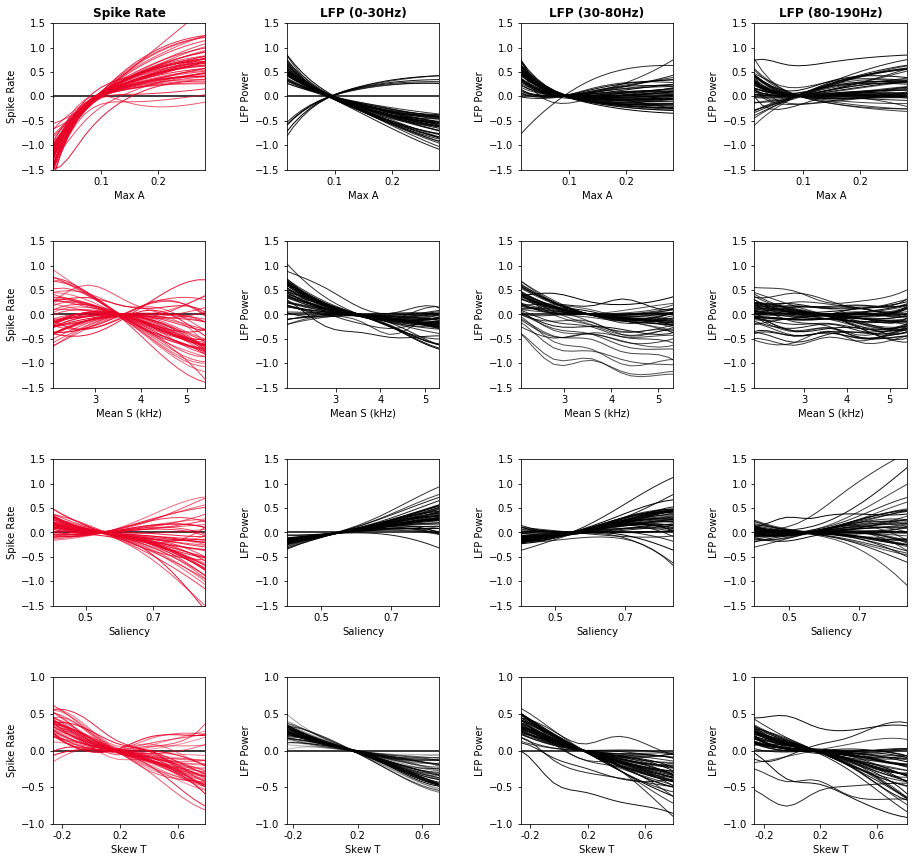

In [3]:
data_dir = '/auto/tdrive/mschachter/data'
agg_file = os.path.join(data_dir, 'aggregate', 'acoustic_encoder_decoder.h5')
agg = AcousticEncoderDecoderAggregator.load(agg_file)

draw_tuning_curves(agg)